In [1]:
%load_ext rpy2.ipython

In [2]:
%%R
library(phyloseq)
library(vegan)
library(dplyr)
library(ggplot2)

Loading required package: permute
Loading required package: lattice
This is vegan 2.3-0

Attaching package: ‘dplyr’

The following objects are masked from ‘package:stats’:

    filter, lag

The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union



In [4]:
%%R
#install.packages("dplyr")

Installing package into ‘/Users/Thea/Library/R/3.1/library’
(as ‘lib’ is unspecified)
--- Please select a CRAN mirror for use in this session ---
also installing the dependencies ‘assertthat’, ‘R6’, ‘lazyeval’, ‘BH’

trying URL 'http://cran.stat.ucla.edu/src/contrib/assertthat_0.1.tar.gz'
Content type 'application/x-tar' length 10187 bytes
opened URL
downloaded 10187 bytes

trying URL 'http://cran.stat.ucla.edu/src/contrib/R6_2.0.1.tar.gz'
Content type 'application/x-tar' length 120554 bytes (117 Kb)
opened URL
downloaded 117 Kb

trying URL 'http://cran.stat.ucla.edu/src/contrib/lazyeval_0.1.10.tar.gz'
Content type 'application/x-tar' length 20833 bytes (20 Kb)
opened URL
downloaded 20 Kb

trying URL 'http://cran.stat.ucla.edu/src/contrib/BH_1.58.0-1.tar.gz'
Content type 'application/x-tar' length 8727864 bytes (8.3 Mb)
opened URL
downloaded 8.3 Mb

trying URL 'http://cran.stat.ucla.edu/src/contrib/dplyr_0.4.2.tar.gz'
Content type 'application/x-tar' length 642959 bytes (627 Kb)
opened

In [3]:
%%R
physeq = import_biom("../../SeqData/otu_table.tax.meta.biom", parseFunction = parse_taxonomy_greengenes)
physeq = subset_samples(physeq,sample_data(physeq)$Trtmt!="B")

In [4]:
%%R
md = sample_data(physeq)

In [5]:
%%R
otu_tab = otu_table(physeq) %>% data.frame

In [6]:
%%R
colnames(otu_tab) = colnames(otu_table(physeq))

In [7]:
from cogent.maths.stats.rarefaction import rarefaction
import pandas.rpy.common as com
from numpy import vstack, arange, mean
import pandas as pd

/opt/virt_env/lib/python2.7/site-packages/pandas/rpy/__init__.py:11: FutureWarning: The pandas.rpy module is deprecated and will be removed in a future version. We refer to external packages like rpy2. 
See here for a guide on how to port your code to rpy2: http://pandas.pydata.org/pandas-docs/stable/r_interface.html
  FutureWarning)


In [8]:
def get_raref_vector(data, stride=10, iters=25):
    rare_data = vstack([[len(h.nonzero()[0]) for h in rarefaction(data, stride=stride)] \
                        for i in range(iters)])
    X = arange(stride,data.sum()+stride,stride)
    return X, mean(rare_data, axis=0)

In [9]:
otu_tab = com.load_data("otu_tab")

In [10]:
%%time
# This takes a few minutes
dfs = {}
for sid in otu_tab.columns:
    counts = otu_tab[sid]
    x, raref_data = get_raref_vector(counts, iters=10)
    dfs[sid] = pd.DataFrame(data={"x" : x, "y" : raref_data})  

CPU times: user 1min 27s, sys: 293 ms, total: 1min 27s
Wall time: 1min 28s


In [11]:
d = pd.concat(dfs, axis=0)
d.reset_index(inplace=True)
d.drop(["level_1"], axis=1, inplace=True)
d.rename(columns={"level_0" : "SampleID"}, inplace=True)
d.head()

,SampleID,x,y
0,1,10,9.8
1,1,20,18.7
2,1,30,27.4
3,1,40,35.5
4,1,50,42.8


In [12]:
d = com.convert_to_r_dataframe(d, strings_as_factors=True)
%Rpush d

In [13]:
%%R
d<-data.frame(d)

In [14]:
%%R
md = sample_data(physeq) %>% data.frame %>% add_rownames("SampleID")

In [15]:
%%R
head(md)

Source: local data frame [6 x 11]

  SampleID         DNA Description BarcodeSequence Cosm OrigBarcodes Month
1        1 1.872090888  MIneralDNA    TGTTATCGCACA   12 TGTGCGATAACA     3
2       67 0.648827278  MIneralDNA    AATGTCCGTGAC   42 GTCACGGACATT   2.5
3     67.2 0.648827278  MIneralDNA    TACTTCGCTCGC   42 GCGAGCGAAGTA   2.5
4     74.2 1.292650729  MIneralDNA    GCCTGAATTTAC   16 GTAAATTCAGGC   2.5
5      102 21.62300816  MIneralDNA    GGACCGAACTCA   12 TGAGTTCGGTCC     3
6       58 0.484351505  MIneralDNA    ATGTCGAGAGAA   13 TTCTCTCGACAT   2.5
Variables not shown: LinkerPrimerSequence (chr), Trtmt (chr), MyID (chr), Buff
  (chr)


Joining by: "SampleID"


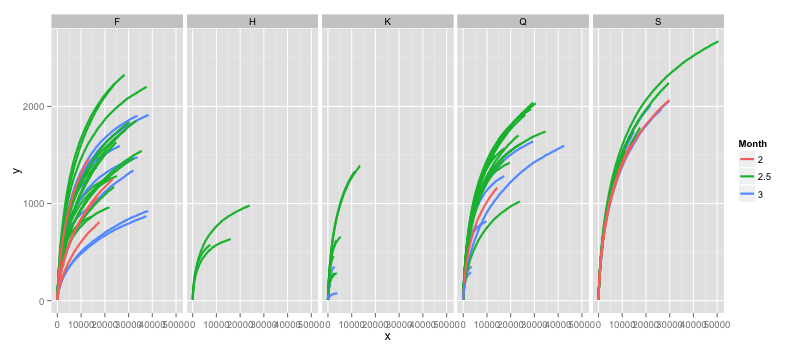

In [17]:
%%R -w 800 -h 350
d.plot = d %>% 
    left_join(md)

p = ggplot(d.plot, aes(x = x, y = y, group = SampleID, color = Month))

p = p + facet_grid(. ~ Trtmt)

p = p + geom_line(size = 1)

p   

Joining by: "SampleID"


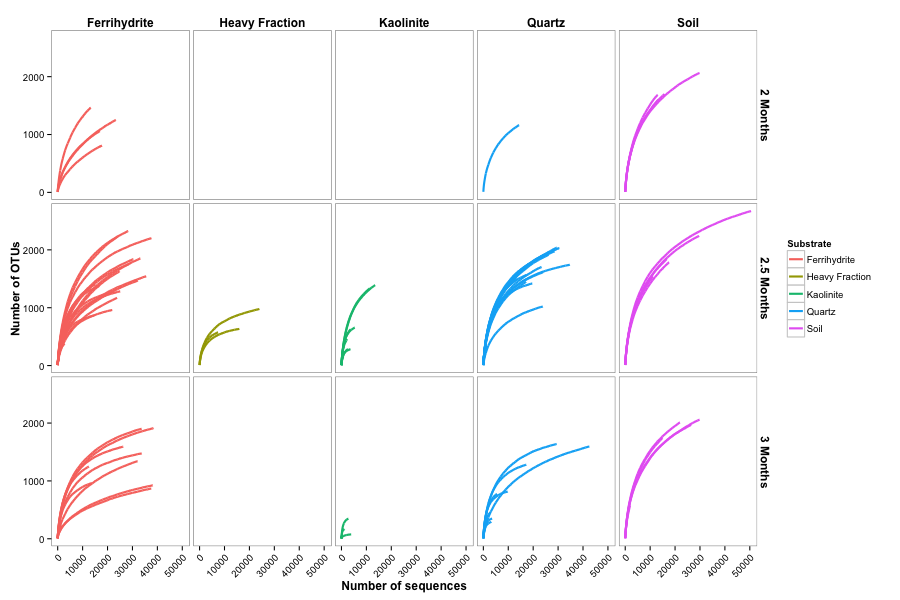

In [17]:
%%R -w 900 -h 600

d.plot = d %>% 
    left_join(md)

d.plot$Trtmt <- as.factor(d.plot$Trtmt)
levels(d.plot$Trtmt) <- c("Ferrihydrite", "Heavy Fraction", "Kaolinite", "Quartz", "Soil")

d.plot$Month <- as.factor(d.plot$Month)
levels(d.plot$Month) <- c("2 Months", "2.5 Months", "3 Months")


p = ggplot(d.plot, aes(x = x, y = y, group = SampleID, color = Trtmt))

p = p + facet_grid(Month ~ Trtmt)

p = p + geom_line(size = 1)

p = p + labs(colour = "Substrate")

p = p + ylab("Number of OTUs") + xlab("Number of sequences") 
#+ xlim(0,10000)
#+ xlim(0,2000) + ylim(0,1000)

p = p + theme_bw() +
  theme(
    plot.background = element_blank()
   ,panel.grid.major = element_blank()
   ,panel.grid.minor = element_blank()
  )

p = p + theme(axis.text.x=element_text(angle = 45, hjust = 1))

p = p + theme(axis.title.x = element_text(size=12, face="bold")
             ,axis.title.y = element_text(size=12, face="bold"))

p = p + theme(strip.text = element_text(size=12, face="bold"),
        strip.background = element_rect(colour="white", fill="white"))

p = p + theme(strip.text.x = element_text(size=12, face="bold"),
        strip.background = element_rect(colour="white", fill="white"))

p   